In [2]:
import os
import torch
from torch import nn
import torchtext.vocab as Vocab
import torch.utils.data as Data
import  torch.nn.functional as F
import collections
import os
import random
import tarfile
import torch
from torch import nn
import torchtext.vocab as Vocab
import torch.utils.data as Data
import csv
import sys
import math
import time
import json
import zipfile
from tqdm import tqdm
from PIL import Image
from collections import namedtuple
from IPython import display
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchtext
import numpy as np
from itertools import chain
import torch.optim as optim
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import torch.autograd as autograd
import torchtext.vocab as torchvocab
from torch.autograd import Variable
import tqdm
import os
import time
import re
import pandas as pd
import string
import gensim
import time
import random
import snowballstemmer
import collections
from collections import Counter
from nltk.corpus import stopwords
from itertools import chain
from sklearn.metrics import accuracy_score


import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_ROOT = "/Users/shuxialin/Documents/project/code"
print(torch.__version__, device)

1.3.0.post2 cpu


In [3]:
fname = os.path.join(DATA_ROOT, "aclImdb_v1.tar.gz")
if not os.path.exists(os.path.join(DATA_ROOT, "aclImdb")):
    print("从压缩包解压...")
    with tarfile.open(fname, 'r') as f:
        f.extractall(DATA_ROOT)

In [4]:
class GlobalMaxPool1d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool1d, self).__init__()
    def forward(self, x):
         # x shape: (batch_size, channel, seq_len)
        return F.max_pool1d(x, kernel_size=x.shape[2]) # shape: (batch_size, channel, 1)

In [5]:
sentences = []
lines = []
with open("/Users/shuxialin/Documents/flip/01and03/data/se07_test.xml", 'r') as fileobj :
    for line in fileobj :
        lines.append(line)
        
lines = lines[1:]

for line in lines :
    tokens = (line.split('<')[1]).split('>')
    sentences.append(tokens[-1])

sen_se07 = sentences[:1000]

se07_classes = []

with open('/Users/shuxialin/Documents/flip/01and03/data/se07_test.emotions.gold', 'r') as flie :
    for line in flie:
        token = (line.split())[1:]
        a = token.index(max(token))
        se07_classes.append(a)
        
train_data = []
test_data = [] 

for i in range(800):
    train_data.append([sen_se07[i],se07_classes[i]])
for i in range(200):
    test_data.append([sen_se07[i+800],se07_classes[i+800]])

In [6]:
def preprocess_imdb(data, vocab):
    max_l = 100  # 将每条评论通过截断或者补0，使得长度变成500

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))

    tokenized_data = get_tokenized_imdb(data)
    features = torch.tensor([pad([vocab.stoi[word] for word in words]) for words in tokenized_data])
    labels = torch.tensor([score for _, score in data])
    return features, labels

In [7]:
def get_tokenized_imdb(data):
    """
    data: list of [string, label]
    """
    def tokenizer(text):
        return [tok.lower() for tok in text.split(' ')]
    return [tokenizer(review) for review, _   in data]

In [8]:
def get_tokenized_imdb(data):
    """
    data: list of [string, label]
    """
    def tokenizer(text):
        return [tok.lower() for tok in text.split(' ')]
    return [tokenizer(review) for review, _   in data]

In [9]:
def tokenizer(text):
    return [tok.lower() for tok in text.split(' ')]

train_tokenized = []
test_tokenized = []
for review, score in train_data:
    train_tokenized.append(tokenizer(review))
for review, score in test_data:
    test_tokenized.append(tokenizer(review))

vocab = set(chain(*train_tokenized))
vocab_size = len(vocab)

In [10]:
def get_vocab_imdb(data):
    tokenized_data = get_tokenized_imdb(data)
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    return Vocab.Vocab(counter, min_freq=2)

vocab = get_vocab_imdb(train_data)
'# words in vocab:', len(vocab)

('# words in vocab:', 812)

In [11]:
batch_size = 64
preprocess_imdb(train_data, vocab)
train_set = Data.TensorDataset(*preprocess_imdb(train_data, vocab))
test_set = Data.TensorDataset(*preprocess_imdb(test_data, vocab))
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_set, batch_size)

In [12]:
class TextCNN(nn.Module):
    def __init__(self, vocab, embed_size, kernel_sizes, num_channels):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size)
        # 不参与训练的嵌入层
        self.constant_embedding = nn.Embedding(len(vocab), embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 6)
        # 时序最大池化层没有权重，所以可以共用一个实例
        self.pool = GlobalMaxPool1d()
        self.convs = nn.ModuleList()  # 创建多个一维卷积层
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(in_channels = 2*embed_size, 
                                        out_channels = c, 
                                        kernel_size = k))

    def forward(self, inputs):
        # 将两个形状是(批量大小, 词数, 词向量维度)的嵌入层的输出按词向量连结
        embeddings = torch.cat((
            self.embedding(inputs), 
            self.constant_embedding(inputs)), dim=2) # (batch, seq_len, 2*embed_size)
        # 根据Conv1D要求的输入格式，将词向量维，即一维卷积层的通道维(即词向量那一维)，变换到前一维
        embeddings = embeddings.permute(0, 2, 1)
        # 对于每个一维卷积层，在时序最大池化后会得到一个形状为(批量大小, 通道大小, 1)的
        # Tensor。使用flatten函数去掉最后一维，然后在通道维上连结
        encoding = torch.cat([self.pool(F.relu(conv(embeddings))).squeeze(-1) for conv in self.convs], dim=1)
        # 应用丢弃法后使用全连接层得到输出
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [13]:
num_epochs = 80
embed_size = 300
num_hiddens = 100
num_layers = 2
bidirectional = True
batch_size = 64
labels = 6
lr = 0.001
embed_size, kernel_sizes, nums_channels = 300, [3, 4, 5], [100, 100, 100]
net = TextCNN(vocab, embed_size, kernel_sizes, nums_channels)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)

In [14]:
glove_vocab = Vocab.GloVe(name='6B', dim=300, cache=os.path.join(DATA_ROOT, "glove"))

In [15]:

def load_pretrained_embedding(words, pretrained_vocab):
    """从预训练好的vocab中提取出words对应的词向量"""
    embed = torch.zeros(len(words), pretrained_vocab.vectors[0].shape[0]) # 初始化为0
    oov_count = 0 # out of vocabulary
    for i, word in enumerate(words):
        try:
            idx = pretrained_vocab.stoi[word]
            embed[i, :] = pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count += 0
    if oov_count > 0:
        print("There are %d oov words.")
    return embed

net.embedding.weight.data.copy_(
    load_pretrained_embedding(vocab.itos, glove_vocab))
net.embedding.weight.requires_grad = False # 直接加载预训练好的, 所以不需要更新它


In [16]:
result = []
loss_all = []
acc_all = []
loss_test = []
acc_test = []
for epoch in range(num_epochs):
    start = time.time()
    train_loss, test_losses = 0, 0
    train_acc, test_acc = 0, 0
    
    n, m = 0, 0
    for feature, label in train_iter:
        n += 1
        net.zero_grad()
        feature = Variable(feature)
        label = Variable(label)
        score = net(feature)
        loss = loss_function(score, label)
        #loss = nn.CrossEntropyLoss()
        loss.backward()
        optimizer.step()
        train_acc += accuracy_score(torch.argmax(score.cpu().data,
                                                 dim=1), label.cpu())
        train_loss += loss.cpu().item()
    with torch.no_grad():
        for test_feature, test_label in test_iter:
            m += 1
            test_feature = test_feature
            test_label = test_label
            test_score = net(test_feature)
            result.append(test_score)
            test_loss = loss_function(test_score, test_label)
            test_acc += accuracy_score(torch.argmax(test_score.cpu().data,
                                                    dim=1), test_label.cpu())
            test_losses += test_loss
    end = time.time()
    runtime = end - start
    loss_all.append(train_loss / n)
    acc_all.append(train_acc / n)
    loss_test.append(test_losses.data / m)
    acc_test.append(test_acc / m)
    print('epoch: %d, train loss: %.4f, train acc: %.2f, test loss: %.4f, test acc: %.2f, time: %.2f' %
          (epoch, train_loss / n, train_acc / n, test_losses.data / m, test_acc / m, runtime))



epoch: 0, train loss: 1.8482, train acc: 0.15, test loss: 1.7911, test acc: 0.16, time: 6.05
epoch: 1, train loss: 1.8079, train acc: 0.19, test loss: 1.8082, test acc: 0.19, time: 5.89
epoch: 2, train loss: 1.7688, train acc: 0.23, test loss: 1.7455, test acc: 0.25, time: 5.57
epoch: 3, train loss: 1.7802, train acc: 0.23, test loss: 1.7999, test acc: 0.23, time: 5.58
epoch: 4, train loss: 1.7731, train acc: 0.23, test loss: 1.8192, test acc: 0.26, time: 5.42
epoch: 5, train loss: 1.7456, train acc: 0.24, test loss: 1.8250, test acc: 0.18, time: 5.45
epoch: 6, train loss: 1.7694, train acc: 0.23, test loss: 1.8250, test acc: 0.17, time: 5.46
epoch: 7, train loss: 1.7537, train acc: 0.23, test loss: 1.8420, test acc: 0.22, time: 5.50
epoch: 8, train loss: 1.7406, train acc: 0.25, test loss: 1.8012, test acc: 0.21, time: 5.51
epoch: 9, train loss: 1.7488, train acc: 0.27, test loss: 1.7738, test acc: 0.18, time: 5.51
epoch: 10, train loss: 1.7594, train acc: 0.26, test loss: 1.8152, tes

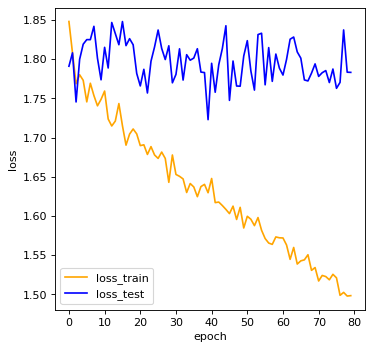

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
import numpy as np

x =[i for i in range(80)]

plt.figure(figsize=(5,5),dpi=80)

plt.plot(x,loss_all,label="loss_train",color="orange")
plt.plot(x,loss_test,label="loss_test",color="blue")
 
#设置x轴刻度
plt.xlabel('epoch') #X轴标签
plt.ylabel("loss") #Y轴标签
# plt.yticks(range(0,9)
plt.legend()
 
#plt.legend(handles=[A,B],labels=["train","test"])
 
plt.show()
plt.savefig("textCNN_loss.png", dpi=600)

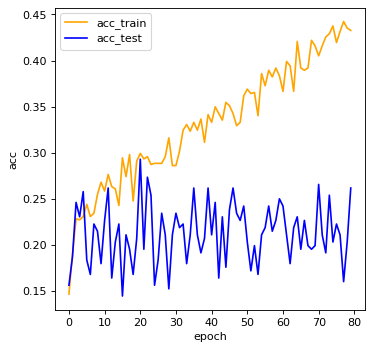

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import numpy as np

x =[i for i in range(80)]

plt.figure(figsize=(5,5),dpi=80)

plt.plot(x,acc_all,label="acc_train",color="orange")
plt.plot(x,acc_test,label="acc_test",color="blue")
 
#设置x轴刻度
plt.xlabel('epoch') #X轴标签
plt.ylabel("acc") #Y轴标签
# plt.yticks(range(0,9)
plt.legend()
 
#plt.legend(handles=[A,B],labels=["train","test"])
 
plt.show()
plt.savefig("textCNN_acc.png", dpi=600)

In [100]:
print(max(acc_all))
print(max(acc_test))
print(min(loss_all))
print(min(loss_test))

0.6382211538461539
0.328125
1.2431888121824999
tensor(1.6737)
